In [1]:
from time import time
import numpy as np
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import gpr
import mcmc
import forAustin as fa

In [2]:
GP = gpr.GPR(
    '/data4/paper/fox/DES/austinFull.fits',
    500,
    sample=np.array([-0.2, 0, 0, 0.2]),
    verbose=True,
    eps=0,
    test_size=0.2,
    random_state=0)

Extracting exposure from fits file...
Filename: /data4/paper/fox/DES/austinFull.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  Exposures     1 BinTableHDU     47   2820R x 19C   [1D, 1D, 4A, 1D, 8A, 1D, 1J, 1J, 1D, 1D, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  2  RESIDUALS     1 BinTableHDU     25   73818788R x 8C   [I, J, D, D, D, D, D, L]   

Extracting exposure data...
Splitting data into training and testing sets...
Generating white noise covariance function...


Generating elliptical covariance function...
Solving for posterior...
Posterior found in 0.01 seconds.

Current Log Marginal Likelihood: -1349.764634754812
Standard deviation of validation residuals: dx 7.84, dy 14.489
Standard deviation of Gaussian Process residuals: dx 9.804, dy 10.202
The ratio of std(valid) / std(GP): dx 0.8, dy 1.42


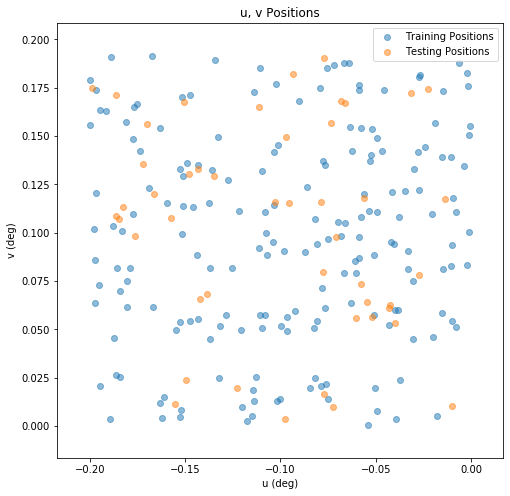

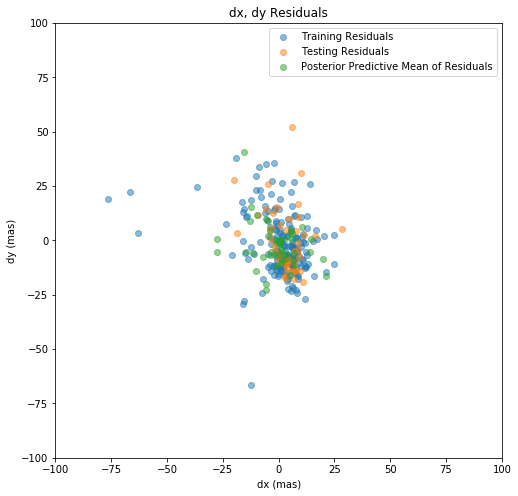

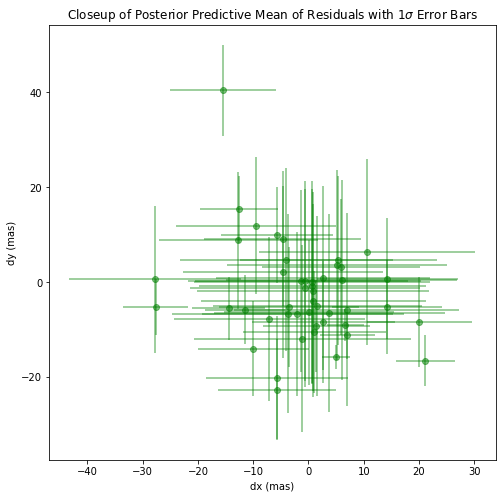

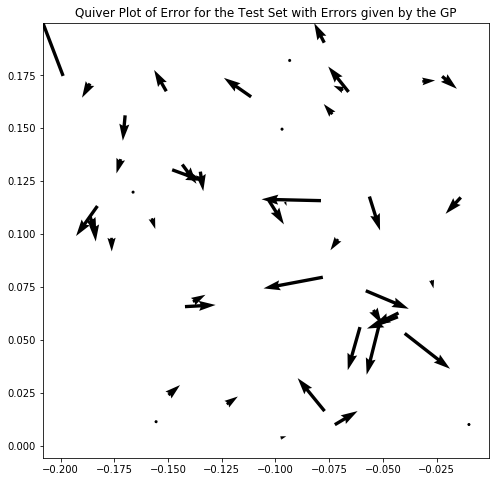

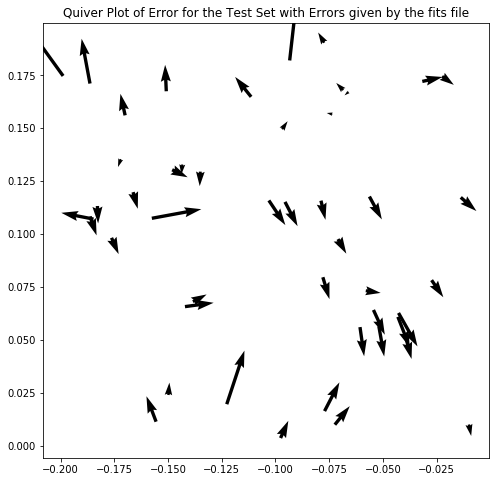

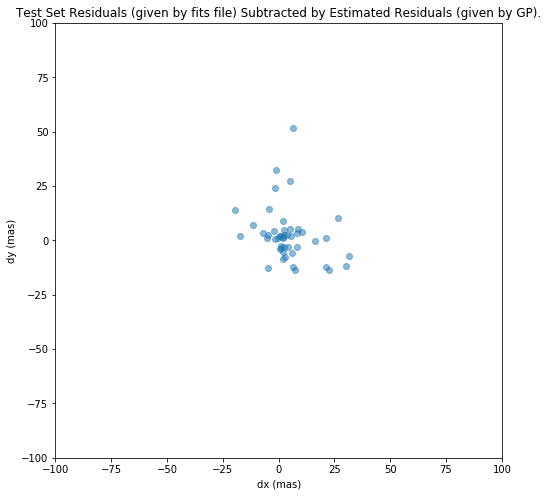

In [3]:
var_s = 460
sigma_x = 0.00175
sigma_y = 0.025
phi = (0 * u.deg).to(u.rad).value
theta = (var_s, sigma_x, sigma_y, phi)
GP.fit(theta)
GP.summary()